In [1]:
import os
import io
import zipfile
import numpy as np
import scipy as sp
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
from pyproj import Proj, transform

from sklearn import preprocessing
from sklearn.cluster import KMeans

try:
    import urllib2 as urllib
except ImportError:
    import urllib.request as urllib

pd.set_option('display.max_columns', 500)
style.use('fivethirtyeight')
%matplotlib inline
plt.rcParams['figure.figsize'] = 15, 6

In [2]:
def clean(df, col='eui', use_log=True, nonneg=False, nstd=2, onesided=None):
    """Takes the logarithm of EUI for a particular building type and filters out
    examples that fall outside the threshold of two standard deviations.
    
    Returns outlier-free dataframe."""
    
    onesided = nonneg if onesided is None else onesided
    try:
        if nonneg:
            df = df[df[col] >= 0]
        if use_log:
            df = df[df[col] != 0]
            vals = np.log10(df[col].astype(float))
        else:
            vals = df[col].astype(float)
    except ValueError:
        return df
    
    if nstd:
        vals_centered = vals - np.mean(vals)
        if not onesided:
            vals_centered = np.abs(vals_centered)
        return df[ vals_centered < nstd*np.std(vals) ]
    return df

def p(a):
    print(a)
    return a

In [3]:
years = map(str, [2013, 2014, 2015, 2016])
eui_cols = ['EUI_{}'.format(y) for y in years]

ll84_urls = {
    '2016': "http://www.nyc.gov/html/gbee/downloads/excel/nyc_benchmarking_disclosure_data_reported_in_2016.xlsx",
    '2015': "http://www.nyc.gov/html/gbee/downloads/excel/2015_nyc_cy2014__ll84_disclosure_data.xlsx",
    '2014': "http://www.nyc.gov/html/gbee/downloads/excel/150428_2014_nyc_ll84_disclosure.xlsx",
    '2013': "http://www.nyc.gov/html/gbee/downloads/excel/2013_nyc_ll84_disclosure.xlsx",
#     '2012': "http://www.nyc.gov/html/gbee/downloads/excel/2012_nyc_cy2011_ll84_disclosure_data.xls"
}

PLUTO_cache = 'data/pluto16.csv'
PLUTO_url = 'https://www1.nyc.gov/assets/planning/download/zip/data-maps/open-data/nyc_pluto_16v2%20.zip'

In [51]:
if os.path.isfile(PLUTO_cache):
    # Read from cache
    df_pluto = pd.read_csv(PLUTO_cache)
else:
    print('Downloading...')
    
    remotezip = urllib.urlopen(PLUTO_url).read()
    with zipfile.ZipFile(io.BytesIO(remotezip)) as z:
        df_pluto = pd.concat([
            pd.read_csv(z.open(p(f)))
            for f in z.namelist()
            if os.path.splitext(f)[1] == '.csv'
        ])
    
    df_pluto.to_csv(PLUTO_cache, index=False)
    
df_pluto = df_pluto[['BBL', 'Borough','LotArea', 'BldgArea', 'ComArea', 'ResArea', 
                     'OfficeArea', 'RetailArea', 'NumFloors', 'UnitsRes', 'UnitsTotal', 
                     'YearBuilt', 'XCoord', 'YCoord', 'ZipCode', 'Address']]
    
print(df_pluto.shape)
df_pluto.head()

(858370, 16)


,BBL,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,3.000010e+09,BK,151930,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JOHN STREET
1,3.000010e+09,BK,19682,154400,154400,0,17160,0,9.0,0,90,1920,987838.0,195989.0,11201.0,10 JAY STREET
2,3.000018e+09,BK,0,102534,4686,97848,0,4686,12.0,42,44,0,987624.0,195992.0,11201.0,1 JOHN STREET
3,3.000030e+09,BK,387060,0,0,0,0,0,0.0,0,0,0,988568.0,196151.0,11201.0,JAY STREET
4,3.000030e+09,BK,6384,0,0,0,0,0,0.0,0,0,0,NaN,NaN,11201.0,JAY STREET


In [55]:
dfs_ll84 = {}
for year, url in ll84_urls.items():
    local_fname = 'data/LL84_{}.csv'.format(year)
    if os.path.isfile(local_fname):
        dfs_ll84[year] = pd.read_csv(local_fname)
    else:
        dfs_ll84[year] = pd.read_excel(url)
        dfs_ll84[year].to_csv(local_fname, encoding='utf-8')
dfs_ll84.keys()

['2015', '2014', '2016', '2013']

In [46]:
for y in years:
    print y, dfs_ll84[y].columns

2013 Index([u'Unnamed: 0', u'BBL', u'Street Number', u'Street Name', u'Borough',
       u'Zip', u'Benchmarking Submission', u'Entry Number',
       u'Site EUI\n(kBtu/ft2)', u'Weather Normalized Source EUI\n(kBtu/ft2)',
       u'Indoor Water Intensity (All Water Sources)\n(gal/ft2)',
       u'Reported Water Method', u'ENERGY STAR Score',
       u'Total GHG Emissions\n(MtCO2e)',
       u'Property Floor Area (Buildngs and Parking)\n(ft2)',
       u'Primary Property Type - Self Selected', u'Number of Buildings',
       u'Reported BINs'],
      dtype='object')
2014 Index([u'Unnamed: 0', u'Record Number', u'NYC Borough, Block, and Lot (BBL)',
       u'Co-reported BBL Status', u'BBLs Co-reported',
       u'Reported NYC Building Identificaiton Numbers (BINs)',
       u'Street Number', u'Street Name', u'Borough', u'Zip Code',
       u'DOF Benchmarking Submission Status', u'Site EUI\n(kBtu/ft2)',
       u'Weather Normalized Site EUI\n(kBtu/ft2)', u'Source EUI\n(kBtu/ft2)',
       u'Weather Norma

In [47]:
for y in years:
    print y, [c for c in dfs_ll84[y].columns if np.any([kw in c for kw in ['Water', 'Gas', 'Intensity', 'Occupancy']])]

2013 ['Indoor Water Intensity (All Water Sources)\n(gal/ft2)', 'Reported Water Method']
2014 ['Municipally Supplied Potable Water - Indoor Intensity (gal/ft\xc2\xb2)', 'Automatic Water Benchmarking Eligible', 'Reported Water Method']
2015 ['Municipally Supplied Potable Water - Indoor Intensity (gal/ft\xc2\xb2)', 'Automatic Water Benchmarking Eligible', 'Reported Water Method']
2016 ['Occupancy', 'Metered Areas  (Water)', 'Weather Normalized Site Electricity Intensity (kWh/ft\xc2\xb2)', 'Weather Normalized Site Natural Gas Intensity (therms/ft\xc2\xb2)', 'District Hot Water Use (kBtu)', 'District Chilled Water Use (kBtu)', 'Natural Gas Use (kBtu)', 'Weather Normalized Site Natural Gas Use (therms)', 'Water Use (All Water Sources) (kgal)', 'Municipally Supplied Potable Water - Indoor Intensity (gal/ft\xc2\xb2)', 'DEP Provided Water Use (kgal)', 'Automatic Water Benchmarking Eligible', 'Reported Water Method']


2013
Indoor Water Intensity (All Water Sources)\n(gal/ft2)
ENERGY STAR Score
Total GHG Emissions\n(MtCO2e)

2014
Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)
ENERGY STAR Score
Total GHG Emissions\n(MtCO2e)
Direct GHG Emissions\n(MtCO2e)
Indirect GHG Emissions\n(MtCO2e)

2015
Municipally Supplied Potable Water - Indoor Intensity (gal/ft²) **
ENERGY STAR Score
Total GHG Emissions\n(MtCO2e)
Direct GHG Emissions\n(MtCO2e)
Indirect GHG Emissions\n(MtCO2e)

2016
ENERGY STAR Score
Total GHG Emissions\n(MtCO2e)
Direct GHG Emissions\n(MtCO2e)
Indirect GHG Emissions\n(MtCO2e)

Diesel #2 Use (kBtu)
Fuel Oil #1 Use (kBtu)
Fuel Oil #2 Use (kBtu)
Fuel Oil #4 Use (kBtu)
Fuel Oil #5 & 6 Use (kBtu)

DEP Provided Water Use (kgal)
District Steam Use (kBtu)
District Hot Water Use (kBtu)
District Chilled Water Use (kBtu)
Water Use (All Water Sources) (kgal)
Municipally Supplied Potable Water - Indoor Intensity (gal/ft2)
Natural Gas Use (kBtu)
Weather Normalized Site Natural Gas Intensity (therms/ft2)

In [56]:
# Keep BBL, Energy, and Floor Data
keepCol = ['BBL', 'Site EUI\n(kBtu/ft2)', 'Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2013'] = dfs_ll84['2013'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2013', 'floorArea_2013'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)', 
           'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2014'] = dfs_ll84['2014'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2014', 'floorArea_2014'])))

keepCol = ['NYC Borough, Block, and Lot (BBL)', 'Site EUI\n(kBtu/ft2)',
          'DOF Property Floor Area (Buildngs and Parking)\n(ft2)']
dfs_ll84['2015'] = dfs_ll84['2015'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2015', 'floorArea_2015'])))

keepCol = ['NYC Borough, Block and Lot (BBL)', r'Site EUI (kBtu/ft²)', r'DOF Property Floor Area (ft²)', 'Occupancy',
          'Primary Property Type - Self Selected', 'Municipally Supplied Potable Water - Indoor Intensity (gal/ft²)', 
           'Natural Gas Use (kBtu)', 'Metered Areas (Energy)', 'Metered Areas  (Water)']
dfs_ll84['2016'] = dfs_ll84['2016'][keepCol].rename(columns=dict(zip(keepCol, ['BBL', 'EUI_2016', 'floorArea_2016', 'Occupancy','TYPE_2016', 'water_intensity', 'naturalgas_use'])))
dfs_ll84['2016']['naturalgas_intensity'] = dfs_ll84['2016']['naturalgas_use'] / dfs_ll84['2016']['floorArea_2016']

In [57]:
df84 = reduce(
    lambda df1, df2: df1.merge(df2, left_on='BBL', right_on='BBL', how='inner'),
    [dfs_ll84[year] for year in years]
)

print(df84.values.shape)
df84.head()

(15518, 16)


,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity
0,1000047501,102.0,2428325.0,92.5,2621563.0,149,2542563.0,133.8,2542563.0,100.0,Office,26.43,38618831.6,Whole Building,Whole Building,15.188938
1,1000057501,119.6,1338000.0,134.5,1354691.0,113.8,1354691.0,135.8,1354691.0,100.0,Office,18.67,NaN,Whole Building,Whole Building,NaN
2,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,NaN,See Primary BBL,NaN,NaN,See Primary BBL,See Primary BBL,NaN
3,1003620001,30.3,5207812.0,See Primary BBL,458591.0,See Primary BBL,458591.0,NaN,NaN,NaN,See Primary BBL,NaN,NaN,See Primary BBL,See Primary BBL,NaN
4,1000090001,99.5,852840.0,78.5,845018.0,81.3,845018.0,71.4,845018.0,100.0,Office,15.05,NaN,Whole Building,Whole Building,NaN


In [36]:
df_types = df84[['TYPE_2016', 'BBL']].groupby('TYPE_2016').count()
df_types[df_types.BBL > 50].sort_values('BBL', ascending=False)

,BBL
TYPE_2016,
Multifamily Housing,10924
Office,1275
See Primary BBL,480
College/University,301
Hotel,230
Non-Refrigerated Warehouse,175
Mixed Use Property,138
Other,125
Retail Store,123


In [62]:
dfmf84 = df84[df84['TYPE_2016'] == 'Multifamily Housing']
print(dfmf84.values.shape)
dfmf84.head()

(10924, 16)


,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity
13,1011200022,62.4,64899.0,54.2,64899.0,65.4,64899.0,22.4,64899.0,80.0,Multifamily Housing,NaN,464150.0,Whole Building,Not Available,7.151882
16,1000157502,50.1,227463.0,36.6,259076.0,78,259076.0,42.7,259076.0,100.0,Multifamily Housing,NaN,164557.7,Whole Building,Not Available,0.635172
17,1000157502,50.1,227463.0,36.6,259076.0,78,259076.0,42.7,259076.0,100.0,Multifamily Housing,NaN,164557.7,Whole Building,Not Available,0.635172
18,3068180025,49.7,138476.0,NaN,132000.0,66.9,132000.0,62.3,132000.0,100.0,Multifamily Housing,NaN,7075499.9,Whole Building,Whole Building,53.602272
19,1011860091,60.9,63121.0,70.9,58266.0,68.6,58266.0,68.3,58266.0,100.0,Multifamily Housing,26.45,67417.0,Whole Building,Whole Building,1.157056


In [63]:
df = dfmf84.merge(df_pluto, on='BBL', how='inner')
print(df.values.shape)
df.head()

(10923, 31)


,BBL,EUI_2013,floorArea_2013,EUI_2014,floorArea_2014,EUI_2015,floorArea_2015,EUI_2016,floorArea_2016,Occupancy,TYPE_2016,water_intensity,naturalgas_use,Metered Areas (Energy),Metered Areas (Water),naturalgas_intensity,Borough,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,YearBuilt,XCoord,YCoord,ZipCode,Address
0,1011200022,62.4,64899.0,54.2,64899.0,65.4,64899.0,22.4,64899.0,80.0,Multifamily Housing,NaN,464150.0,Whole Building,Not Available,7.151882,MN,7532,64899,0,64899,0,0,14.0,31,31,1905,990009.0,221143.0,10023.0,15 WEST 67 STREET
1,1000157502,50.1,227463.0,36.6,259076.0,78,259076.0,42.7,259076.0,100.0,Multifamily Housing,NaN,164557.7,Whole Building,Not Available,0.635172,MN,13928,179856,10000,168748,0,10000,45.0,283,284,1930,979922.0,196558.0,10004.0,20 WEST STREET
2,1000157502,50.1,227463.0,36.6,259076.0,78,259076.0,42.7,259076.0,100.0,Multifamily Housing,NaN,164557.7,Whole Building,Not Available,0.635172,MN,13928,179856,10000,168748,0,10000,45.0,283,284,1930,979922.0,196558.0,10004.0,20 WEST STREET
3,3068180025,49.7,138476.0,NaN,132000.0,66.9,132000.0,62.3,132000.0,100.0,Multifamily Housing,NaN,7075499.9,Whole Building,Whole Building,53.602272,BK,32000,132000,0,132000,0,0,6.0,125,125,1954,995423.0,159501.0,11229.0,1840 EAST 13 STREET
4,1011860091,60.9,63121.0,70.9,58266.0,68.6,58266.0,68.3,58266.0,100.0,Multifamily Housing,26.45,67417.0,Whole Building,Whole Building,1.157056,MN,6641,58266,0,58266,0,0,12.0,25,25,1910,989141.0,225102.0,10024.0,316 WEST 79 STREET


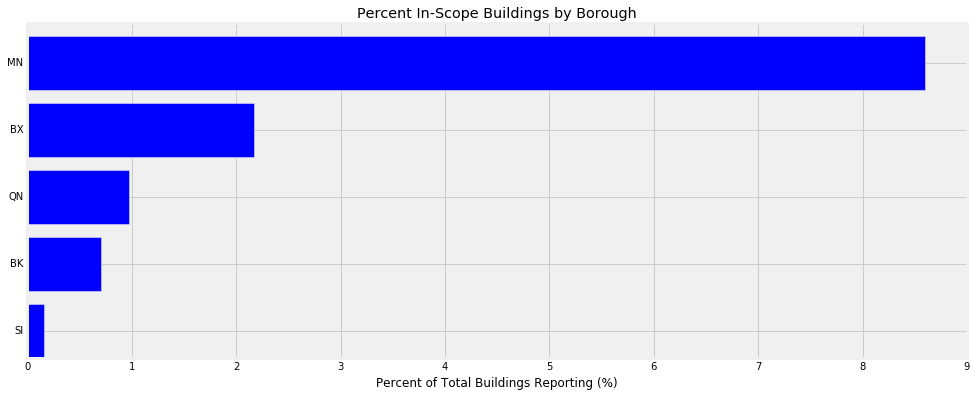

In [64]:
prop = (df.groupby('Borough').count()['ZipCode'] / df_pluto.groupby('Borough').count()['ZipCode']).sort_values()
xprop = np.arange(len(prop))
plt.barh(xprop, prop.values * 100., color='blue')
plt.title('Percent In-Scope Buildings by Borough')
plt.xlabel('Percent of Total Buildings Reporting (%)')
plt.yticks(xprop + 0.4, prop.index);

In [65]:
for col in eui_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
print(df[eui_cols].dtypes)

dfnan = df[eui_cols][np.any(np.isnan(df[eui_cols + ['water_intensity', 'naturalgas_intensity']]), axis=1)]
print(dfnan.values.shape)
dfnan.head()

EUI_2013    float64
EUI_2014    float64
EUI_2015    float64
EUI_2016    float64
dtype: object
(7380, 4)


,EUI_2013,EUI_2014,EUI_2015,EUI_2016
0,62.4,54.2,65.4,22.4
1,50.1,36.6,78.0,42.7
2,50.1,36.6,78.0,42.7
3,49.7,NaN,66.9,62.3
7,68.4,NaN,88.7,63.2


In [66]:
print(df.shape)
df = df.dropna()
print(df.shape)

(10923, 31)
(3538, 31)


In [67]:
df['Longitude'], df['Latitude'] = transform(
    Proj(init='epsg:2263', preserve_units=True), # ny/li projection
    Proj(init='epsg:4326'), # wgs84 projection
    df.XCoord.values, df.YCoord.values# x, y
)

df[['Address', 'Latitude', 'Longitude']].head()

,Address,Latitude,Longitude
4,316 WEST 79 STREET,40.784528,-73.982338
5,377 RECTOR PLACE,40.709851,-74.017891
6,350 ALBANY STREET,40.710107,-74.017570
9,300 ALBANY STREET,40.709915,-74.016859
10,380 RECTOR PLACE,40.709077,-74.018060


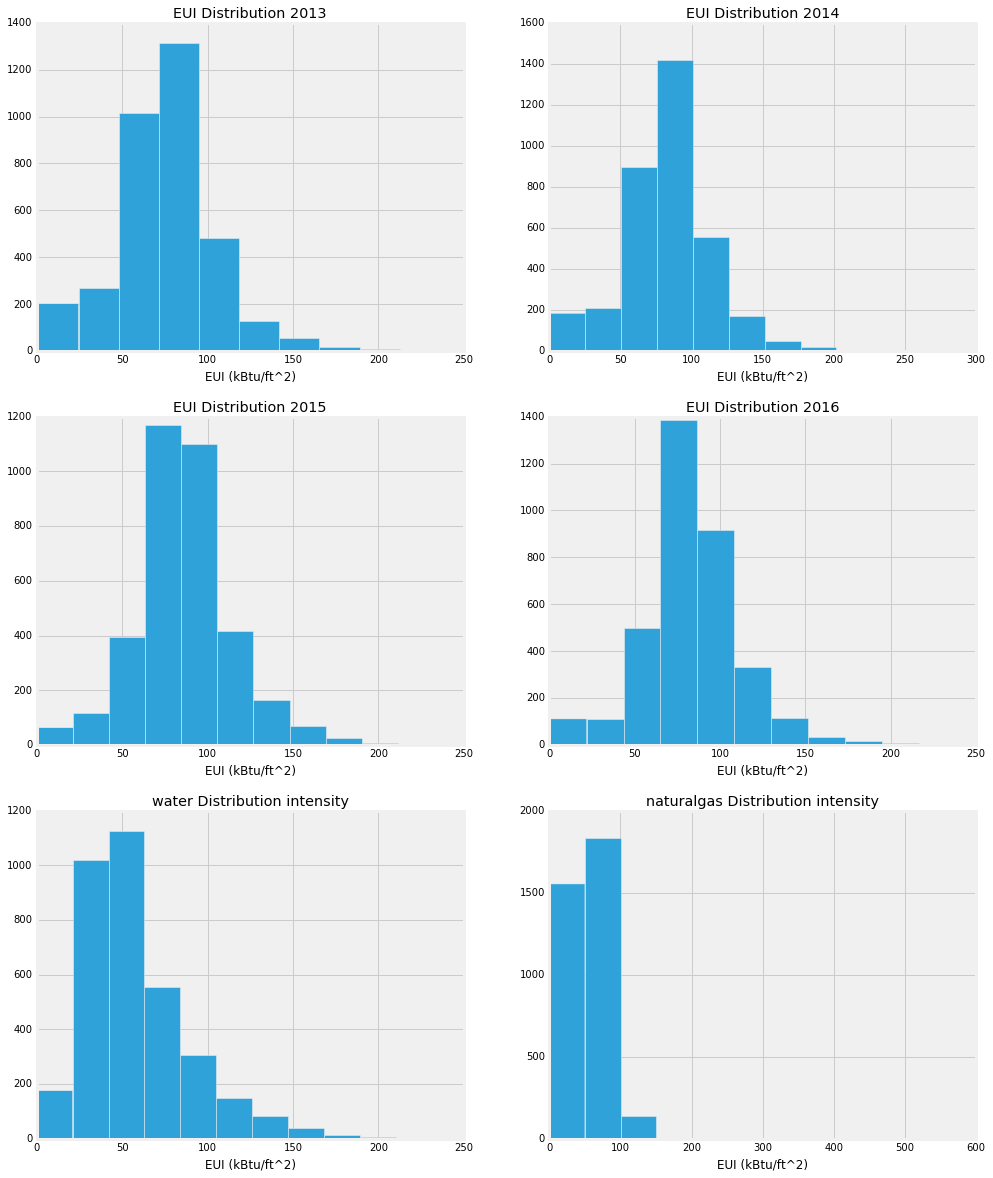

In [70]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(eui_cols + ['water_intensity', 'naturalgas_intensity'], 1):
    plt.subplot(3,2,i)
    plt.title(col.replace('_', ' Distribution '))
    plt.xlabel('EUI (kBtu/ft^2)')
    plt.hist(clean(df, col, nonneg=True)[col])

In [71]:
# remove outliers for all eui columns and get description. doesn't update df
reduce(lambda df, col: clean(df, col), eui_cols + ['water_intensity', 'naturalgas_intensity'], df)[eui_cols + ['water_intensity', 'naturalgas_intensity']].describe()

,EUI_2013,EUI_2014,EUI_2015,EUI_2016,water_intensity,naturalgas_intensity
count,2682.000000,2682.000000,2682.000000,2682.000000,2682.000000,2682.000000
mean,79.446048,88.303095,89.875615,86.261484,59.819213,54.497948
std,24.595685,23.669295,22.674536,21.483881,29.752176,27.961051
min,17.400000,33.700000,40.400000,40.900000,13.030000,2.311788
25%,65.200000,72.925000,74.800000,71.400000,38.722500,39.657079
50%,77.400000,85.300000,87.150000,83.400000,52.825000,58.226004
75%,91.900000,101.000000,101.275000,98.275000,73.412500,71.500246
max,209.700000,189.500000,175.900000,168.600000,192.580000,148.413333


In [65]:
df.to_csv('merged-w-latlon.csv', index=False)

## Add further data processing...

In [66]:
def makeCorrPlots(x, y, df, log=False):
    
    """Takes two variables as inputs, fits a univariate linear regression model,
    and outputs the scatter plot, linear fit and correlation coefficient"""
    
    # drop nans
    try:
        tmp = df[[x,y]]
        tmp = tmp.dropna()
        X, Y = tmp[x].astype(float), tmp[y].astype(float)
    except:
        print(x, y)
        return
    
    if not len(X) or not len(Y):
        return
    
    if log:
        X[X == 0] = 1e-12;
        X = np.log10(X)
    
    # fit univariate regression
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(X, Y)
    
    # plot2
    plt.scatter(X, Y, color='b', alpha=0.5)
    plt.plot(X, intercept + slope*X, color='firebrick')
    plt.title('{} v. {}{} (corr= {:.2f})'.format(y, 'log ' if log else '', x, np.corrcoef(X, Y)[0][1]))

In [69]:
eui_cols = {col for col in df.columns if 'eui' in col.lower()}
non_eui_cols = set(df.columns) - eui_cols
eui_cols, non_eui_cols = list(eui_cols), list(non_eui_cols)

plot_cols = 'LotArea	BldgArea	ComArea	ResArea	OfficeArea	RetailArea	NumFloors	UnitsRes	UnitsTotal'.split('\t')

In [74]:
df2 = pd.concat([
    df[plot_cols + ['EUI_{}'.format(y), 'floorArea_{}'.format(y)]].rename(columns={
        'EUI_{}'.format(y): 'EUI',
        'floorArea_{}'.format(y): 'floorArea'
    })
    for y in years
])

if df2.EUI.dtype != float:
    df2 = df2[df2.EUI != 'Not Available']
df2.EUI = pd.to_numeric(df2.EUI)

print(df2.dtypes)
df2.head()

LotArea         int64
BldgArea        int64
ComArea         int64
ResArea         int64
OfficeArea      int64
RetailArea      int64
NumFloors     float64
UnitsRes        int64
UnitsTotal      int64
EUI           float64
floorArea     float64
dtype: object


,LotArea,BldgArea,ComArea,ResArea,OfficeArea,RetailArea,NumFloors,UnitsRes,UnitsTotal,EUI,floorArea
0,111382,1888126,1888126,0,1848626,39500,50.0,0,52,102.0,2428325.0
1,54023,1024229,1024229,0,1024229,0,40.0,0,7,119.6,1338000.0
4,29481,845018,845018,0,839651,5367,32.0,0,9,99.5,852840.0
5,23080,544015,544015,0,542515,0,42.0,0,0,79.7,574095.0
6,39985,896956,896956,0,864078,2878,35.0,0,9,139.4,859807.0


In [75]:
for col in plot_cols:
    df = clean(df, col, nstd=0, nonneg=True)
    df2 = clean(df2, col, nstd=0, nonneg=True)
    
for col in eui_cols:
    df = clean(df, col, nstd=4, nonneg=True)
df2 = clean(df2, 'EUI', nstd=4, nonneg=True)

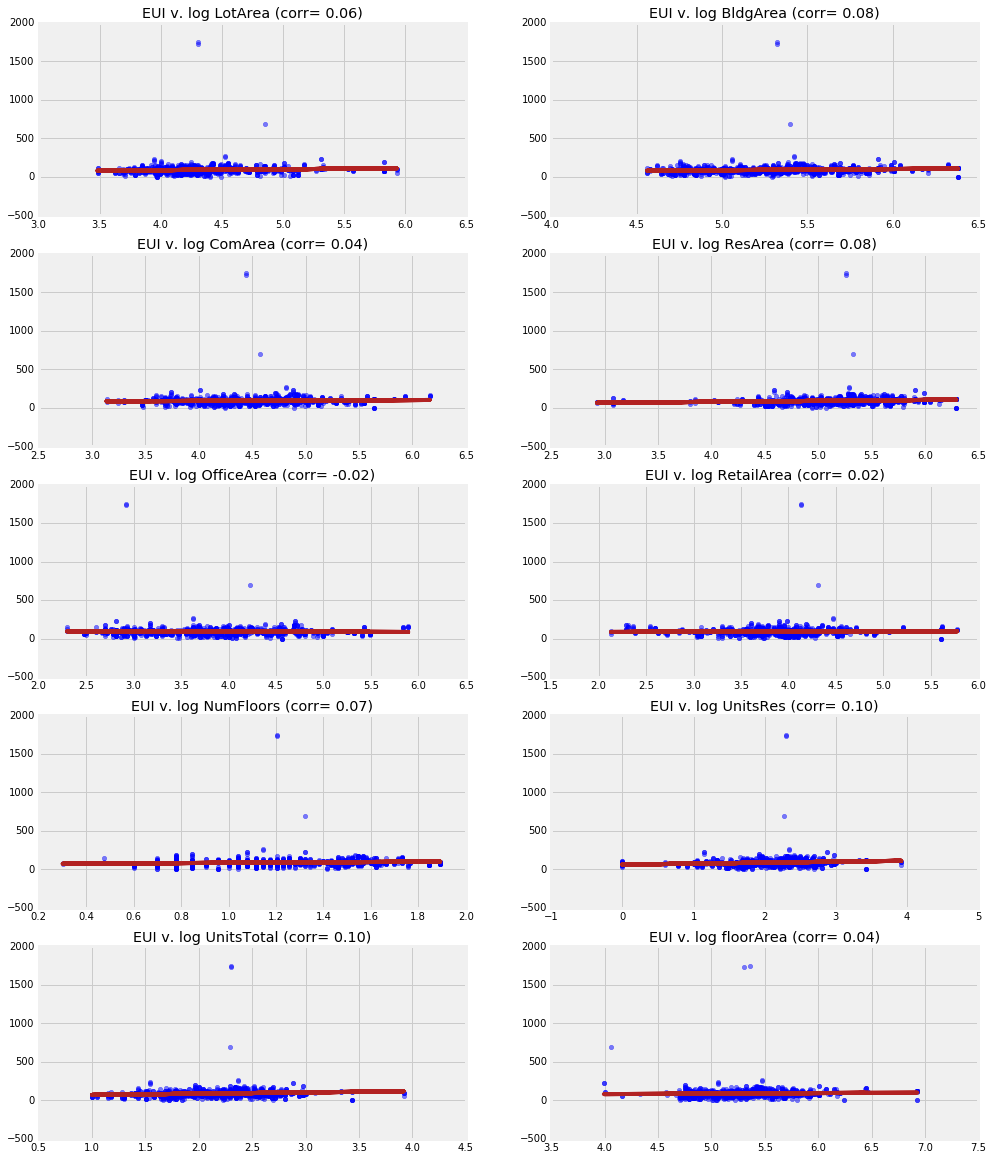

In [76]:
plt.figure(figsize=(15, 20))
for i, col in enumerate(plot_cols + ['floorArea'], 1):
    if not col in df2.columns:
        continue
    plt.subplot(5, 2, i)
    makeCorrPlots(col, 'EUI', df2, log=True)

## Add OLS here....